# Data Science Intern Assessment: Predicting players' rank

### Notebook by Joshua Belandres

# 1. Introduction

We are given data on player's performance in ranked Starcraft games. The task is to build a model that predicts a player's rank given the information in the dataset.

The target variable is an ordinal variable ranging from 1 to 8, 1 being the lowest possible player rank and 8 being the highest. The features of the dataset include player attributes such as age, playing time and in game actions.

# 2. Required libraries
- numpy
- pandas
- seaborn
- matplotlib
- sklearn

# 3. Exploratory Data Analysis

Need to check the integrity of the dataset during the inital EDA, before we start selecting and training models.

This involves addressing:
- missing values
- normalization needs
- anolmalies/outliers
- correlation/multicollinearity
- class imbalances
- feature importance

In [13]:
import pandas as pd
import numpy as np

# Download the source dataset into a pandas dataframe
player_data = pd.read_csv("starcraft_player_data.csv", na_values=["?"]) # null values are recorded as "?"s

# Subset data that will be used for model development
df = player_data.drop(columns="GameID")
df.head()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


### 3.1 Check for missing values

The variables Age, HoursPerWeek, and TotalHours have null values. These variables are likely to have high predictive power and thus we should still devise a plan to include them in the modeling process. 



In [14]:
n_na_rows = df.isnull().any(axis=1).sum()
print(f"{round(n_na_rows/len(df)*100,3)}% of rows ({n_na_rows}) have missing values")

1.679% of rows (57) have missing values


In [15]:
df.isnull().sum()

LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

Notice that all the missing values occur in the columns Age, HoursPerWeek, and TotalHours

In [16]:
class_counts = df['LeagueIndex'].value_counts().sort_index()

# Calculate the percentage of null values in each class
null_percentage = df[df.isnull().any(axis=1)].groupby('LeagueIndex').size() / class_counts * 100
null_percentage = null_percentage.fillna(0)  # Replace NaN values with 0
print("Percentage of LeagueIndex class that have missing values:")
print(round(null_percentage,3))

Percentage of LeagueIndex class that have missing values:
1      0.000
2      0.000
3      0.000
4      0.000
5      0.248
6      0.000
7      0.000
8    100.000
dtype: float64


As shown, 100% of the 8th rank class (professional league) have missing values. Thus we wouldn't want to just remove these rows as we would be removing an entire class from our dataset. To keep the class we could drop the 3 columns where the missing values occur (Age, HoursPerWeek, and TotalHours). This would be bad in the case that these variables have high predictive power, however it may be the only way to keep the 8th rank class in the dataset as data augmentation (making new data) is not possible as there is not prescedent for what those columns look like for that class.

Note that only ~0.25% of the observations of the 5th ranked class have missing values so removing these rows would likely have a negligle change in model performance.

### 3.2 Multicollinearity check
Need to check 2 or more variables are highly correlated as multicollinearity. We generally want to avoid multicollinearity when training models because it can introduce instability and uncertainty in the model's parameter estimates, leading to challenges in interpreting the effects of individual variables and potentially misleading conclusions about their importance. 

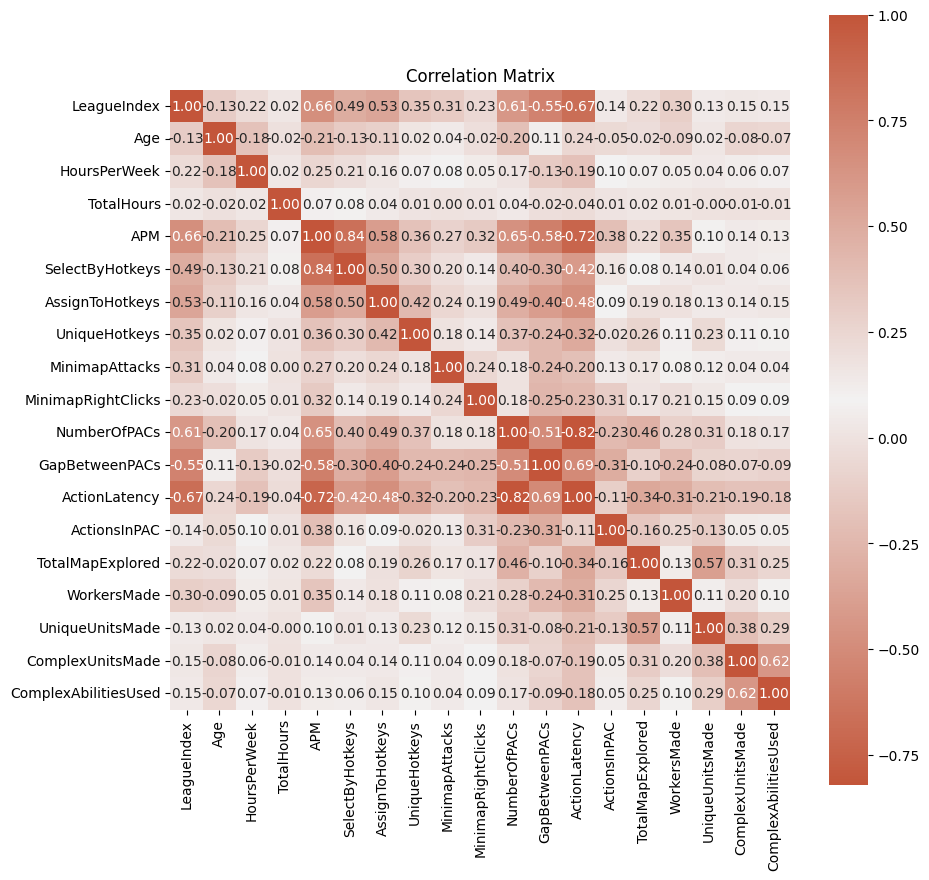

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(20, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=cmap, square=True, fmt=".2f")

plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows there are three variables with correlation coefficients that may indicate the existence of multicollinearity. This analysis uses the standard correlation threshold of 0.7
- [APM, SelectByHotkeys] (0.84)
- [APM, ActionLatency] (-0.72)
- [NumberOfPACs, ActionLatency] (-0.82)

Also notice that the columns with missing values (Age, HoursPerWeek, and TotalHours) are not strongly correlated with LeagueIndex, so it may be viable to drop these columns, allowing us to keep the entire population of the 8th ranked class.

### 3.3 Check for class imbalances

The previous analysis shows signs of class imbalance. Lets investigate.

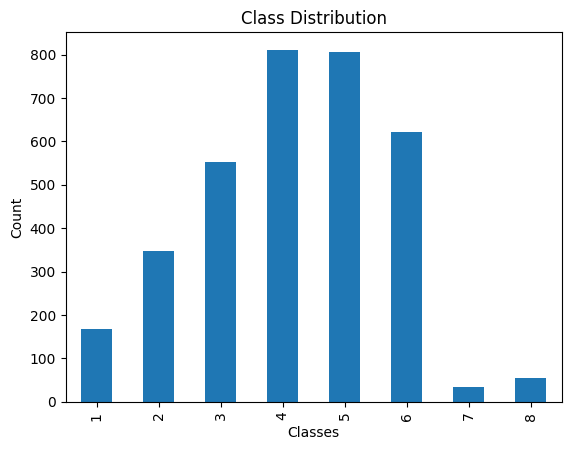

Class counts:
1    167
2    347
3    553
4    811
5    806
6    621
7     35
8     55
Name: LeagueIndex, dtype: int64


In [18]:
import matplotlib.pyplot as plt

class_counts = df['LeagueIndex'].value_counts().sort_index()
class_counts.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

print("Class counts:")
print(class_counts)

The charted class distribution shows severe class imbalance in the player data. This is to be expected as it is natural that there are a less players with the lowest ranking, which consist of players who started and quit the game, and that there are even fewer players with the highest ranking, as these ranks are the most difficult to attain.

The sharp decrease in ranked Master (6) players to Grand Master (7) players is surprising. It is even more surprising that there are more professional (8)players than Grand Masters. This may be explained by domain knowledge of Starcraft and its players. It may be that the barrier to entry is drastically higher for Grand Master rank and that once a player reaches this rank, they likely have the ability to become a professional. It may also be that there is missing data for the 7th and 8th ranked classes.

The severe class imbalance is likely to negatively effect the performance of any model trained on this data. If we were to take an equal number of samples from each class we would be excluding majority of the data as rank 7 only has 35 observations while the other classes (besides 8) have 150+ observations. If class imbalances cannot be addressed it should be noted when interpreting the output of the models.

### 3.4 Descriptive Statistics

In [19]:
# temporarily drop the null rows so we can view the summary statistics
df.dropna().describe()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,4.120731,21.650389,15.909527,960.421809,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,1.448170,4.206357,11.964495,17318.133922,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,3.000000,19.000000,8.000000,300.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4.000000,21.000000,12.000000,500.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,5.000000,24.000000,20.000000,800.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,7.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


The variables are on drastically different scales. For example the mean of ActionLatency is 64.209584 while the stats per timestamp, such as MinimapRightClicks are very close to zero with deviations orders of magnitude smaller than ActionLatency and others. Thus normalization techniques should be applied to optimize performance.

It is also good that upon inspecting the minimum values that there are no negative values that would need to be cleaned up, as none of the variables should be negative.



In [20]:
df[df.TotalHours>10000]

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
770,5,22.0,16.0,20000.0,248.0490,0.023703,0.000391,7,0.000000,0.000205,0.004651,37.8795,45.3760,4.7560,21,0.001526,6,0.000000,0.000000
1793,5,18.0,24.0,1000000.0,281.4246,0.023428,0.000799,5,0.000041,0.000447,0.005136,28.1164,36.1266,5.8522,29,0.001328,6,0.000000,0.000000
1978,4,22.0,10.0,18000.0,152.2374,0.011983,0.000206,1,0.000016,0.000364,0.003351,52.1896,63.9811,4.9575,19,0.000680,5,0.000000,0.000000
2216,3,24.0,20.0,10260.0,76.5852,0.000780,0.000197,0,0.000063,0.000316,0.002438,42.9480,84.6340,5.9107,27,0.000450,10,0.000246,0.000358
2324,6,20.0,8.0,25000.0,247.0164,0.015794,0.000438,8,0.000308,0.001339,0.004645,17.6471,37.1837,6.5944,29,0.001860,6,0.000000,0.000012


It is not possible for someone to play 1000000 (~114 years) hours of Starcraft. This is likely an error in the data. Since we are planning to drop TotalHours from the dataset, it is okay to ignore these for now as the rest of the data in these rows do not look out of the ordinary.

In [21]:
df[df.TotalHours<df.HoursPerWeek]

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
184,2,24.0,12.0,10.0,44.5248,0.001870,0.000152,0,0.000051,0.000126,0.002047,66.3500,97.9259,3.3580,11,0.000606,3,0.0,0.000000
976,3,16.0,28.0,3.0,69.5748,0.001016,0.000371,3,0.000000,0.000239,0.003623,57.3775,69.4389,3.3234,18,0.000550,7,0.0,0.000490
1244,3,18.0,42.0,30.0,95.6886,0.003646,0.000540,10,0.000000,0.000304,0.001620,33.1064,110.3333,8.0833,7,0.000776,4,0.0,0.000000
1865,1,20.0,20.0,16.0,73.2594,0.000954,0.000136,5,0.000000,0.000099,0.003866,52.8103,69.4359,3.2981,21,0.000694,6,0.0,0.000000
2458,1,16.0,56.0,50.0,49.4184,0.001511,0.000143,2,0.000000,0.000306,0.001306,71.1111,104.6875,6.2500,12,0.000653,6,0.0,0.000000
2799,2,19.0,20.0,12.0,57.1536,0.001584,0.000332,5,0.000011,0.000266,0.003190,61.4216,81.3611,3.0174,17,0.000864,7,0.0,0.000055
2946,1,17.0,28.0,20.0,91.2876,0.003119,0.000543,7,0.000000,0.000081,0.002878,22.0000,59.4126,4.9371,14,0.000906,6,0.0,0.000081


It is not possible to have a greater number of HoursPerWeek than TotalHours. This is also an error in the data. Again, since we are planning to drop these columns from the dataset, we will still keep these rows as the other columns do not look out of the ordinary.

# 4. Preprocess Data

### 4.1 Clean data

In [22]:
# Dropping specified columns with missing values and invalid data
df = df.drop(columns={"Age","HoursPerWeek","TotalHours"})

### 4.2 Split data into feature/target sets

In [23]:
X = df.iloc[:, 1:]  # Feature matrix (all columns except the first one)
y = df.iloc[:, 0]  # Target variable (first column)

### 4.3 Scaling data by standardization

I think its best to scale data using stardarization rather than the common minmax scaling technique. This is because while there is a lower bound on the features (zero) there is no well defined upper bound. This means that it is possible to have a value in the testing data that is greater than the maximum value used in training the model. This can hurt performance in these cases. Therefore we use the robust standard scaler which can handle data with outliers or a wide range of values, making it suitable for situations where the upper bound is undefined.

In [24]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 5. Modeling

In [26]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def model_cv(model, X_data, y_data, k=5):
    '''
    Use k fold cross-validation to fit the model and make predictions on the test data
    '''

    # Perform cross-validation and obtain the evaluation metrics
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    results = cross_validate(model, X_data, y_data, cv=5, scoring=scoring)

    # Obtain predicted labels using cross-validation
    y_pred = cross_val_predict(model, X_data, y_data, cv=5)

    return results, y_pred

def print_performance(results, y_pred, y_true):
    '''
    Print performance metrics
    '''
    # Calculate and print the mean scores across all folds
    mean_accuracy = results['test_accuracy'].mean()
    mean_precision = results['test_precision_macro'].mean()
    mean_recall = results['test_recall_macro'].mean()
    mean_f1 = results['test_f1_macro'].mean()

    print("Mean Accuracy:", round(mean_accuracy,4))
    print("Mean Precision:", round(mean_precision,4))
    print("Mean Recall:", round(mean_recall,4))
    print("Mean F1-Score:", round(mean_f1,4))

    # Compute overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)

    # Compute accuracy for each class
    class_accuracies = {}

    # Get unique class labels
    unique_classes = set(y_true)

    # Iterate over each class
    for class_label in unique_classes:
        # Filter the predictions and true labels for the current class
        class_mask = (y_true == class_label)
        class_y_pred = y_pred[class_mask]
        class_y_true = y_true[class_mask]

        # Compute accuracy for the current class
        class_accuracy = accuracy_score(class_y_true, class_y_pred)
        print(f"Accuracy for class {class_label}: {round(class_accuracy,4)}")

### 5.1 Multi-Class Logistic Regression Model with all features

Assumes a linear relationship between the variables

In [27]:
from sklearn.linear_model import LogisticRegression

# Create logistic regression model
log_reg_model = LogisticRegression(multi_class='multinomial',
                                    class_weight='balanced',
                                    solver='newton-cg',
                                    random_state=2)

# K-fold cross-validation for the logistic regression model
results, y_pred = model_cv(log_reg_model, X_scaled, y)
print_performance(results, y_pred, y)

Mean Accuracy: 0.3449
Mean Precision: 0.3346
Mean Recall: 0.4227
Mean F1-Score: 0.3483
Accuracy for class 1: 0.5988
Accuracy for class 2: 0.3372
Accuracy for class 3: 0.2532
Accuracy for class 4: 0.2947
Accuracy for class 5: 0.3226
Accuracy for class 6: 0.4187
Accuracy for class 7: 0.4286
Accuracy for class 8: 0.7273


### 5.2 Multi-Class Support Vector Machine Model

Use an SVM to see if the relationships between our features and target are non-linear

In [28]:
from sklearn.svm import SVC

# Create an SVM classifier
svm_model = SVC(class_weight='balanced',
                kernel='rbf',
                decision_function_shape='ovo')

# K-fold cross-validation for the support vector machine model
results, y_pred = model_cv(svm_model, X_scaled, y)
print_performance(results, y_pred, y)

Mean Accuracy: 0.3496
Mean Precision: 0.3292
Mean Recall: 0.37
Mean F1-Score: 0.3351
Accuracy for class 1: 0.5749
Accuracy for class 2: 0.3285
Accuracy for class 3: 0.2477
Accuracy for class 4: 0.2713
Accuracy for class 5: 0.3313
Accuracy for class 6: 0.5105
Accuracy for class 7: 0.1143
Accuracy for class 8: 0.5818


It does not seem as if there are non-linear relationships between the features and target as the baseline logistic regression performs better on all of the performance metrics. Thus I won't spend more time investigating more complex models.

# 6. Next Steps
The data we have does not have enough predictive power to accurately predict players' ranks. It is possible that the variables we originally dropped in order to keep the observations of the 8th ranked class had the most predictive power. After all it would make sense that hours spent playing the game and ones age could be a good indicator of a player's skill. Lets perform a quick experiment to test this hypothesis by restoring Age, TotalHours and HoursPerWeek to the training data. In doing this we will have to drop all observations of the 8th ranked class as these feilds are unpopulated for the class.

In [29]:
# Subset data that will be used for model development
df_new = player_data.drop(columns="GameID")
# Drop null values which effectively drops the 8th ranked class (and a few from the 5th ranked class, negligible)
df_new = df_new.dropna()
# clean the data as there were some previously observed problems with the newly included fields
df_new = df_new[(df_new.TotalHours>df_new.HoursPerWeek) & (df_new.TotalHours<1000000)]

In [30]:
X_new = df_new.iloc[:, 1:]  # Feature matrix (all columns except the first one)
y_new = df_new.iloc[:, 0]  # Target variable (first column)

scaler = RobustScaler()
X_scaled_new = scaler.fit_transform(X_new)

In [31]:
# Create logistic regression model
log_reg_model = LogisticRegression(multi_class='multinomial',
                                    class_weight='balanced',
                                    solver='newton-cg',
                                    max_iter=5000,
                                    random_state=2)

# K-fold cross-validation for the logistic regression model
results, y_pred = model_cv(log_reg_model, X_scaled_new, y_new)
print_performance(results, y_pred, y_new)

Mean Accuracy: 0.3608
Mean Precision: 0.3295
Mean Recall: 0.4151
Mean F1-Score: 0.3389
Accuracy for class 1: 0.5706
Accuracy for class 2: 0.344
Accuracy for class 3: 0.2777
Accuracy for class 4: 0.3136
Accuracy for class 5: 0.3537
Accuracy for class 6: 0.4461
Accuracy for class 7: 0.6


While the is a significant increase in performance, it is hard to say if it is a result of the newly included variables. I expected a significant increase in performance, as we dropped an entire class such that there is one less classification problem for the model to deal with.

# 7. Report

Dear Evil Geniuses Stakeholders,

My analysis on the player data you provided me is complete. I was not able to build a model that can predict a player's rank with high accuracy. However I did gain insights on what would be required to acheive this goal.

Firstly, there was a large imbalance in the data in that the Silver, Gold, Platinum, Diamond, and Master leauges had an adequate amount of data, while the Bronze, GrandMaster and Professional leagues had drastically less data. For example, the leauge with the most amount of data was Platinum, with over 800 players while the GrandMaster league only consisted of 35 players. This severe imbalance makes it harder for models to find patterns in players' data that might give it the ability to make accurate predictions. I understand that the is a natural distribution of players' level, such that there will always be more intermediate players than professional ones, but a more balanced dataset will lead to a more robust and accurate analysis.

Interestingly enough, I found that the leagues with the most data did not have the highest accuracies, when I looked into the prediction accuracies for each player league. In fact the number of observations for each rank and the prediction accuracy of the rank are seemingly inversely proportional such that the ranks with the most data (Silver, Gold, Platinum, Diamond and Master) had lower accuracies than the ranks with less data (Bronze, GrandMaster, and Professional). This may indicate that it is easier for the model to identify players at the extremes (beginner and elite players) rather than distinguishing between the large amount of intermediate players.

In conclusion, we should discuss more about what goals you want to acheive for this data. If there is a reason to distinguish beginners and professionals from intermediate players, then there may be a way to make a decent model with the given data. However, if you wish to make accurate predictions across all ranks, including distinctions between the intermediate players, then you should consider collect additional variables as the ones provided did not perform well. I recommend consulting higher level players, as they have the most domain knowledge, on what factors of gameplay separate players of different skill from one another. These should include aspects of the game that would hypothetically be done differently across leauges. 